## Boilerplate Code

In [1]:
# This cell is only needed on Google Colab
!pip install -q condacolab
!git clone https://github.com/icomse/11th_workshop_mesoscale_modeling.git Monday-CG
import condacolab
condacolab.install()

Cloning into 'Monday-CG'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 158 (delta 18), reused 26 (delta 10), pack-reused 124 (from 1)
Receiving objects: 100% (158/158), 174.99 MiB | 25.89 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Updating files: 100% (47/47), done.
⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...


In [1]:
# This cell is only needed on Google Colab
%%capture
!conda install scipy matplotlib numpy gsd fresnel hoomd
import os
os.chdir("Monday-CG")

This is code to import packages set up some behavior in this notebook. You can safely ignore it.

In [2]:
import hoomd
import matplotlib
import numpy
import gsd, gsd.hoomd
import itertools
%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

# Top-down Coarse graining

## Plot Potential and Force

We will use the LJ potential as an example: https://hoomd-blue.readthedocs.io/en/stable/hoomd/md/pair/lj.html#hoomd.md.pair.LJ. Write functions that compute the pair potential $V$=`V_lj` and the force $F$=`F_lj` between two particles as function of distance `r`. Then plot these functions:

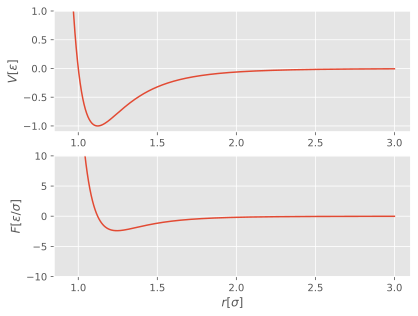

In [13]:
sigma = 1
epsilon = 1
r_cut = 3
r = numpy.linspace(0.95, r_cut, 500)
V_lj = 4*epsilon*((sigma/r)**12-(sigma/r)**6)
F_lj = 24*epsilon*(2*(sigma/r)**13-sigma/r**7)

fig, ax = matplotlib.pyplot.subplots(2,1)
ax[0].plot(r, V_lj)
ax[1].plot(r, F_lj)
ax[1].set_xlabel(r"$r[\sigma]$")
ax[0].set_ylabel(r"$V[\epsilon]$")
ax[1].set_ylabel(r"$F[\epsilon/\sigma]$")
ax[0].set_ylim([-1.1,1])
ax[1].set_ylim([-10,10])
matplotlib.pyplot.show()


Feel free to change the parameters $\sigma=$`sigma`, $\epsilon=$`epsilon` and the cutoff distance `r_cut`. The "size" of the particle is determined by $\sigma$, and the relative attraction well depth is tuned by $\epsilon$.

What do the units on each axis mean? *Hint:* look up [reduced units](https://hoomd-blue.readthedocs.io/en/stable/units.html).

## Define Initial Configuration

We will use `gsd.hoomd.Frames` and hoomd snapshots extensively in this workshop, so make sure the code above is clear and makes sense to you. In addition to the fields we assinged above, there are many other fields:
- velocity `frame.particles.velocity`, `floats` of shape `(N,3)`
- bond types `frame.bonds.typeid`, `ints` of shape `(N)`
- mass `frame.particles.mass`, `floats` of shape `(N)`
- images `frame.particles.images` , `ints` of shape `(N,3)`
- box dimensions `frame.configuration.box`, `float [Lx,Ly,Lz,xy, xz, yz]`.
- timestep `frame.configuration.step`, `int`

which we will use during this workshop. Molecular models also often define `frame.bonds`, `frame.angles`, and `frame.dihedrals`, which we are not using here for simplicity, but the `gsd` format does have those fields too. See [documentation](https://gsd.readthedocs.io/en/latest/python-module-gsd.hoomd.html) for a full list of properties that can be stored in a gsd file.

This is the minimum setup needed for two identical particles of type 'A' in a box with $L=30$, one at (0,0,0) and one at (3,0,0):

In [14]:
frame = gsd.hoomd.Frame()

L = 30
frame.particles.N = 2
frame.particles.position = [[0,0,0],[3.0,0,0]]
frame.configuration.box = [L, L, L, 0, 0, 0]
frame.particles.types = ['A']

## Setup Simple Hoomd Framework

These are the minimal ingredients for setting up a hoomd simulation. First, we do need an [integrator](https://hoomd-blue.readthedocs.io/en/stable/hoomd/md/integrator.html). Here we will not actually do a simulation, so we can safely set the timestep to 0:

In [15]:
integrator = hoomd.md.Integrator(dt=0) # we are not actually doing a simulation, so we can set the timestep to 0

Then we need a [neighbor list](https://hoomd-blue.readthedocs.io/en/stable/hoomd/md/module-nlist.html). Hoomd uses these neighbor lists to compute forces on particles more efficiently.

In [16]:
cell = hoomd.md.nlist.Cell(buffer=0.4)

Now we can define the pair interaction between the two particles we have defined above. Here, we will use the LJ potential as an example.

In [17]:
LJ = hoomd.md.pair.LJ(nlist=cell)
LJ.params[("A", "A")] = dict(epsilon=epsilon, sigma=sigma)
LJ.r_cut[("A", "A")] = r_cut
integrator.forces.append(LJ)

We also need to create the [simulation object](https://hoomd-blue.readthedocs.io/en/stable/hoomd/simulation.html#hoomd.Simulation), which defines the simulation. We assign the `integrator`.

In [18]:
simulation = hoomd.Simulation(device=hoomd.device.auto_select())
simulation.operations.integrator = integrator

Now we can read in the `gsd.hoomd.Frame` object, that holds the information about the intital configuration:

In [19]:
simulation.create_state_from_snapshot(frame)

Let's loop over the distances in array `r` and have hoomd compute the energy and the force one one particle in x-direction at each distance. For this, you will need to set the `x` coordinate of the second particle. We will save the output in arrays `measured_energy` and `measured_forces`. Look up how to get the [energy](https://hoomd-blue.readthedocs.io/en/stable/hoomd/md/pair/lj.html#hoomd.md.pair.LJ.energies) from a hoomd pair interaction:

In [21]:
measured_energy = []
measured_forces = []
for a in r:
    snapshot = simulation.state.get_snapshot()
    snapshot.particles.position[1] = numpy.array([a,0,0])
    simulation.state.set_snapshot(snapshot)

    simulation.run(0)

    measured_energy.append(...)
    measured_forces.append(...)


We can plot the results and compare against our analytical expressions from above

In [ ]:
fig, ax = matplotlib.pyplot.subplots(2,1,sharex=True)
ax[0].plot(...)
ax[0].plot(...)

ax[1].plot(...)
ax[1].plot(...)

ax[1].set_xlabel(r"$r[\sigma]$")
ax[0].set_ylabel(r"$V[\epsilon]$")
ax[1].set_ylabel(r"$F[\epsilon/\sigma]$")
ax[0].set_ylim([-1.1,1])
ax[1].set_ylim([-10,10])
matplotlib.pyplot.show()


### Pair Potential Cutoffs and Interpolation

Hoomd (as well as most other MD simulation packages) has various ways to deal with short ranged [pair potentials](https://hoomd-blue.readthedocs.io/en/stable/hoomd/md/module-pair.html). All interactions/forces need to go to zero at some distance, usually `r_cut`. Hoomd can either just cut a potential (`Pair.mode='none'`), cut and shift (`shift`), or cut and smooth (`xplor`).
Below we will investigate how these different modes impact the shape of the pair interaction and force. This has an impact on thermodyamic quantities!

Note that the below is not how one would run an actual simulation (since multiple LJ potentials are applied simultaneously):

In [ ]:
frame = gsd.hoomd.Frame()

frame.particles.N = 2
frame.particles.position = [[0,0,0],[3.0,0,0]]
frame.configuration.box = [10, 10, 10, 0, 0, 0]
frame.particles.types = ['A']

integrator = hoomd.md.Integrator(dt=0)
cell = hoomd.md.nlist.Cell(buffer=0.4)

LJ_cut = hoomd.md.pair.LJ(nlist=cell)
LJ_cut.params[("A", "A")] = dict(epsilon=epsilon, sigma=sigma)
LJ_cut.r_cut[("A", "A")] = 2.0

LJ_shift = hoomd.md.pair.LJ(nlist=cell)
LJ_shift.params[("A", "A")] = dict(epsilon=epsilon, sigma=sigma)
LJ_shift.r_cut[("A", "A")] = 2.0
LJ_shift.mode = "shift"

LJ_xplor = hoomd.md.pair.LJ(nlist=cell)
LJ_xplor.params[("A", "A")] = dict(epsilon=epsilon, sigma=sigma)
LJ_xplor.r_cut[("A", "A")] = 2.0
LJ_xplor.mode = "xplor"

integrator.forces = [LJ_cut,LJ_shift,LJ_xplor]


simulation = hoomd.Simulation(device=hoomd.device.auto_select())
simulation.operations.integrator = integrator

simulation.create_state_from_snapshot(frame)


measured_energy_shift = []
measured_forces_shift = []
measured_energy_cut = []
measured_forces_cut = []
measured_energy_xplor = []
measured_forces_xplor = []
for a in r:
    snapshot = simulation.state.get_snapshot()
    snapshot.particles.position[1] = ...
    simulation.state.set_snapshot(snapshot)

    simulation.run(0)

    measured_energy_shift.append(...)
    # add all other arrays

# plot results and compare
...
matplotlib.pyplot.show()

## Asakura Oosawa model

Volume fraction of depletant is given by $\phi_d = \frac{\pi}{6}\sigma_d^3\rho_d$, and the AO potential is given by:

\begin{equation}
U_{\mathrm{AO}}(r)= \begin{cases}\infty & \text { for } \quad r \leq \sigma_{\mathrm{c}} \\ -\phi_d\left(\frac{1+q}{q}\right)^3\left[1-\frac{3 r}{2 \sigma_{\mathrm{c}}(1+q)}+\frac{r^3}{2 \sigma_{\mathrm{c}}^3(1+q)^3}\right] & \text { for } \quad \sigma_{\mathrm{c}}<r<\sigma_{\mathrm{c}}+\sigma_{\mathrm{p}} \\ 0 & \text { for } \quad r \geq \sigma_{\mathrm{c}}+\sigma_{\mathrm{p}}\end{cases}
\end{equation}

Implement two functions that return the potential and the force based on the AO model:

In [ ]:
def ao_potential(r, sigma_c, sigma_d, phi_d):
    # add code here
    ...
    return U_AO

def ao_force(r, sigma_c, sigma_d, phi_d):
    # add code here
    ...
    return F_AO

Hoomd does not have the AO potential implemented. For such cases, hoomd allows the user to use a [tabulated definition](https://hoomd-blue.readthedocs.io/en/stable/hoomd/md/pair/table.html) of the potential and the force. This is very useful for nummerical potentials that might arise for various coarse-graining schemes, as well as for testing out different models that are not implemented in hoomd. Hoomd interpolates between the given points in the table:

In [ ]:
sigma_c = 5
sigma_d = 1
phi_d = 0.4

frame = gsd.hoomd.Frame()
frame.particles.N = 2
frame.particles.position = [[0,0,0],[3.0,0,0]]
frame.configuration.box = [30, 30, 30, 0, 0, 0]
frame.particles.types = ['A']

integrator = hoomd.md.Integrator(dt=0)

r_min = sigma_c-0.1
r_cut = sigma_c+sigma_d

cell = hoomd.md.nlist.Cell(buffer=0.4)
r = numpy.linspace(r_min, r_cut, 100, endpoint=False)

UAO = ao_potential(r, sigma_c, sigma_d, phi_d)
FAO = ao_force(r,sigma_c,sigma_d,phi_d)

table = hoomd.md.pair.Table(nlist=cell)
table.params[("A", "A")] = dict(r_min=r_min, U=UAO, F=FAO)
table.r_cut[("A", "A")] = r_cut
integrator.forces = [table]

simulation = hoomd.Simulation(device=hoomd.device.auto_select())
simulation.operations.integrator = integrator
simulation.create_state_from_snapshot(frame)

# add code to loop over all distances and save the energy and force

# add code to plot results
matplotlib.pyplot.show()


This potential and force is not continous, and is not suitable to run a MD simulation with. We could easily do MC simulations. The hard sphere potential cannot be simulated in MD, but is often approximated by the Weeks-Chandler-Anderson (WCA) potential. The WCA potential is a LJ potential that got tunkated at the LJ minium $2^{1/6}\sigma$  and shifted up to zero. We can replace the HS part in the AO model with a WCA (also see [Statt, A., Virnau, P., & Binder, K. (2015). Crystal nuclei in melts: a Monte Carlo simulation of a model for attractive colloids. Molecular Physics, 113(17–18), 2556–2570](https://www.tandfonline.com/doi/pdf/10.1080/00268976.2015.1042937)):

\begin{equation}
U_\mathrm{rep}(r)=  4\left[\left(\frac{b \sigma_c}{r-\epsilon \sigma_c}\right)^{12}+\left(\frac{b \sigma_c}{r-\epsilon \sigma_c}\right)^6-\left(\frac{b \sigma_c}{\sigma_c+q-\epsilon \sigma_c}\right)^{12}-\left(\frac{b \sigma_c}{\sigma_c+q-\epsilon \sigma_c}\right)^6\right]
\end{equation}

Then, the interaction is given by the attractive AO part and this new repulsive part: $U_\mathrm{AO,attractive}+U_\mathrm{rep}$.
Here, we have introduced some more paramters to adjust the repulsive part of the potential, namely $b$ and $\epsilon$. As in the reference, let's use $b=0.01$ and $\epsilon=0.98857 $, which results in $U_\mathrm{softAO}(r=\sigma_c)=1$.

Implement this new potential and the force:

In [ ]:
def soft_ao_potential(r, sigma_c, sigma_d, phi_d,b,epsilon):
    # add code
    ...
    return U_AO


def soft_ao_force(r, sigma_c, sigma_d, phi_d,b,epsilon):
    # add code
    ...
    return F_AO

phi_d = 0.4  # volume fraction of depletant
sigma_d = 1.0  # diamter of depletant
sigma_c = 5.0  # diameter of colloids
phi_c = 0.1  #volume fraction of colloids
b = 0.01
epsilon = 0.98857

r_min = sigma_c-0.1
r_cut = sigma_c+sigma_d

r = numpy.linspace(r_min, r_cut, 100, endpoint=False)

fig, ax = matplotlib.pyplot.subplots(2,1,sharex=True)
# add code to plot both the AO model and the "soft AO" model potential and force

matplotlib.pyplot.show()

Now we can run a small test simulation with this soft AO model. Here, we are making the $z$ direction of the box $L_z$ longer, so that if we get phase coexistence, we get the liquid phase to orient in that direction. This is sometimes called "direct coexistence" method. We will learn (soon!) the details of how to run a proper Langevin simulation:

In [ ]:
phi_d = 0.4  # volume fraction of depletant
sigma_d = 1.0  # diamter of depletant
sigma_c = 5.0  # diameter of colloids
phi_c = 0.2  #volume fraction of colloids
b = 0.01
epsilon = 0.98857

frame = gsd.hoomd.Frame()
L = 38
Lz = 2*L
N  = phi_c*L*L*Lz*6/(numpy.pi*sigma_c**3)

x = numpy.arange(-0.5*L, 0.5*L-sigma_c, sigma_c+0.1)
position = list(itertools.product(x, repeat=3))
N = numpy.round(N).astype(int)

frame.particles.N = N
frame.particles.position = position[0:N]

frame.configuration.box = [L, L, Lz, 0, 0, 0]
frame.particles.types = ['A']

integrator = hoomd.md.Integrator(dt=0.001)

r_min = sigma_c-0.05
r_cut = sigma_c+sigma_d
cell = hoomd.md.nlist.Cell(buffer=0.4)
r = numpy.linspace(r_min, r_cut, 1000, endpoint=False)

# add code to add the new tabulated potential and force to the hoomd simulation
...

simulation = hoomd.Simulation(device=hoomd.device.auto_select(),seed=42)
simulation.operations.integrator = integrator
simulation.create_state_from_snapshot(frame)

simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)

nvt = hoomd.md.methods.Langevin(
    filter=hoomd.filter.All(), kT=1.0
)
integrator.methods.append(nvt)

simulation.run(500_000)
snapshot = simulation.state.get_snapshot()

To see what happened, we can compute a histogram in $z$ direction, which should show if we have one fluid or two phases. Get the $z$ positions from the `snapshot.particles.position` array. Then create a `numpy.histogram`, which you should normalize to get volume fraction from counts. Then plot the result:

In [ ]:
positions_z = ...
hist , edges = numpy.histogram(positions_z, bins=L, range=(-L,+L))

center =  (edges[1:] + edges[:-1])/2
# normalize
hist = hist/...

fig,ax = matplotlib.pyplot.subplots(1,1)
ax.plot(center,hist)
ax.set_xlabel(r"$L_z[\sigma]$")
ax.set_ylabel(r"$\phi_c$")
matplotlib.pyplot.show()
